# Part I : Data collection

#### In this part we chose to download the data of 5 banks, BCP, BANK OF AFRICA , ATTIJARI, CIH and BMCI

In [15]:
file = open("bmci.aspx", "rt") 
bmci = file.read()   
file.close()

file = open("boa.aspx", "rt") 
boa = file.read()         
file.close()    

file = open("tijari.aspx", "rt") 
tijari = file.read()         
file.close()    

file = open("cih.aspx", "rt") 
cih = file.read()         
file.close()    

file = open("bcp.aspx", "rt") 
bcp = file.read()         
file.close()  

In [95]:
import csv 
from bs4 import BeautifulSoup

def aspx_to_csv(name_aspx):
    #we open the file store the text in read_file then close the file
    file = open(name_aspx, "rt") 
    read_file = file.read()         
    file.close()
    
    #we transform it into beautiful soup then find all the the lines that has <span>
    file_soup = BeautifulSoup(read_file)
    
    find_all = file_soup.find_all("span")#We browsed the file 
    #and found out that only span has the content so we will only use lines that has span 
    
    max_len = len(find_all) #this variable will be used as stop condition for the FOR loop to browse the entirety 
    
    lst = []
    #We also found out that every 6 lines of find_all(span) we got another set of data so we decided to 
    # get in every single loop 6 successive lines and make the loop jump by 6, for example in the first loop we get
    # the content in line 0, 1, 2, 3, 4, 5 then second loop 0+6,1+6,2+6,3+6,4+6,5+6
    # for the first line we only get the text since it is just a date, for the other ones we get the text replace the 
    # the comma by a dot so we can transform the string into floats
    for i in range(0,max_len,6):
           lst.append([find_all[i].get_text(),
                       float(find_all[i+1].get_text().replace(',','.')),
                       float(find_all[i+2].get_text().replace(',','.')),
                       float(find_all[i+3].get_text().replace(',','.')),
                       float(find_all[i+4].get_text().replace(',','.')),
                       float(find_all[i+5].get_text().replace(',','.'))])
    #30.8 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
    
    #this part of the code writes our data in a csv file 
    cols= ['date','closing','adjusted','evolution','quantity','volume']
    name = name_aspx.replace('.aspx','')
    with open(name+'_csv.csv', 'w') as f: 
        csv_writer = csv.writer(f)
        csv_writer.writerow(cols) #for the first line, columns
        csv_writer.writerows(lst) #for the other lines, data
            

In [22]:
bcp = BeautifulSoup(bcp)
max_len = len(bcp.find_all("span"))
max_len

4524

In [23]:
%%timeit
bcp_find_all = bcp.find_all("span")
bcp_lst = []

for i in range(0,max_len,6):
       bcp_lst.append([bcp_find_all[i].get_text(),
                       float(bcp_find_all[i+1].get_text().replace(',','.')),
                       float(bcp_find_all[i+2].get_text().replace(',','.')),
                       float(bcp_find_all[i+3].get_text().replace(',','.')),
                       float(bcp_find_all[i+4].get_text().replace(',','.')),
                       float(bcp_find_all[i+5].get_text().replace(',','.'))])
        

12 ms ± 384 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
name = "bcp.aspx"
aspx_to_csv(name)

172 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Part II : Data processing

In [25]:
import csv 

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo

class Stock:
 
    def __init__(self,name):
        self.name = name
        aspx_to_csv(name+".aspx")
        self.data = pd.read_csv(name+'_csv.csv')
        
    def staticgraph(self):
        
        ''' this an instance method that graphs volumes in bars and value in a line'''
        
        fig, ax1 = plt.subplots(figsize=(8, 8))
        ax2 = ax1.twinx()
        ax1.bar(self.data.index,self.data['volume'],color='orange',label='volume')
        ax2.plot(self.data.index,self.data["adjusted"],color='blue',label='value')
        ax1.grid(zorder=0)
        plt.legend()
        plt.show()
        
    def staticgraph_Mm_Sma(self,m,nsma):
        
        ''' this an instance method that graphs volumes in bars 
        and value, Momentum, Simple Moving Average in lines'''
        
        fig, ax1 = plt.subplots(figsize=(8, 8))
        ax2 = ax1.twinx()
        ax1.bar(self.data.index,self.data['volume'],color='orange',label='volume')
        ax2.plot(self.data.index,self.data["adjusted"],color='blue',label='value')
        ax1.grid(zorder=0)
        plt.plot(self.momentum(m),color='red',label='Momentum')
        plt.plot(self.sma(nsma),color='green',label='Moving Average')
        plt.legend()
        plt.show()
        
    
    def dynamicgraph(self): 
        graph1 = go.Scatter(x=self.data.date, y=self.data.closing, name='Value')
        graph2 = go.Scatter(x=self.data.date, y=self.data.volume, name='Volume', yaxis='y2')
        data = [graph1, graph2]
        layout = go.Layout(title=self.name, xaxis=dict(title='Date'), yaxis=dict(title='Value'), 
                           yaxis2=dict(title='Volume', overlaying='y', side='right'))
        # to add shared area of the date
        layout.update(shapes=[dict(type='rect',x0='2022-01-01',y0=0,x1='2022-12-31',y1=self.data["closing"].max(),opacity=0)])
        fig = go.Figure(data=data, layout=layout)
        pyo.iplot(fig)
        
    def dynamicgraph_Mm_Sma(self,m,nsma): 
        graph1 = go.Scatter(x=self.data.date, y=self.data.closing, name='Value')
        graph2 = go.Scatter(x=self.data.date, y=self.data.volume, name='Volume', yaxis='y2')
        graph3 = go.Scatter(x=self.data.date, y=self.momentum(m), name='Moving average (m)', line=dict(color='red'))
        graph4 = go.Scatter(x=self.data.date, y=self.sma(nsma), name='Simple moving average (sma)', line=dict(color='green'))
        data = [graph1, graph2, graph3, graph4]
        layout = go.Layout(title=self.name, xaxis=dict(title='Date'), yaxis=dict(title='Value'), 
                           yaxis2=dict(title='Volume', overlaying='y', side='right'))
        # to add shared area of the date
        layout.update(shapes=[dict(type='rect',x0='2022-01-01',y0=0,x1='2022-12-31',y1=self.data["closing"].max(),opacity=0)])
        fig = go.Figure(data=data, layout=layout)
        pyo.iplot(fig)
        
    def maximumValue(self):
        return self.data['adjusted'].max()
    
    def minimumValue(self):
        return self.data['adjusted'].max()
    
    def maximumVolume(self):
        return self.data['volume'].max()
    
    def maximumQuantity(self):
        return self.data['quantity'].max()
  
    def momentum(self,N):
        length = len(self.data)
        if type(N) is list:
            lst = []
            columns=[]
            for j in range(len(N)):
                m = []
                for i in range(0,length):
                    if i < N[j]:
                        continue
                    else:
                        m.append(self.data['closing'][i] - self.data['closing'][i-N[j]])
                
                lst.append(m)
            df = pd.DataFrame (lst, )
            return lst
        
        else:
            m= []
            for i in range(0,length):
                if i < N:
                    i=N
                else:
                    m.append(self.data['closing'][i] - self.data['closing'][i-N])
            df = pd.DataFrame (m, columns = ['Momentum N= '+str(N)])
            return df
        
    def sma(self,N): 
        windows = self.data['closing'].rolling(N)

        ma = windows.mean()

        malst = ma.tolist()
        lst = malst[N - 1:]
        df = pd.DataFrame (lst, columns = ['SMA N= '+str(N)])
        return df  
    
    

        
stock = Stock("bcp")
stock.data.head(6)

,date,closing,adjusted,evolution,quantity,volume
0,13/01/2023,215.00,215.00,0.00,3428.0,742280.40
1,12/01/2023,215.00,215.00,4.88,16859.0,3553199.85
2,10/01/2023,205.00,205.00,4.03,24880.0,5058099.50
3,09/01/2023,197.05,197.05,1.26,18577.0,3689281.55
4,06/01/2023,194.60,194.60,-5.99,74525.0,14511149.80
5,05/01/2023,207.00,207.00,-5.91,12245.0,2618064.00


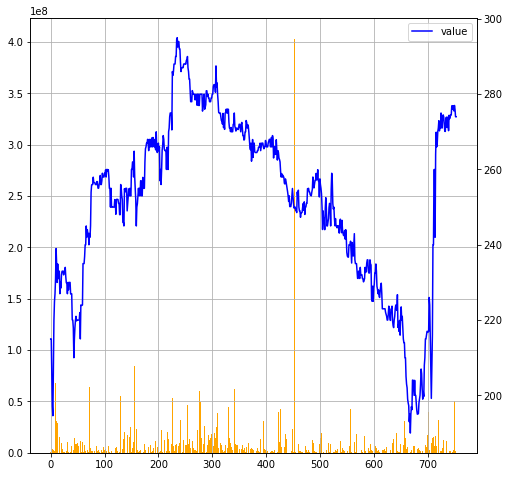

In [88]:
stock.staticgraph()

In [89]:
stock.dynamicgraph()

In [90]:
print('Maximum Value :',stock.maximumValue())
print('Maximum Value :',stock.minimumValue())
print('Maximum Volume :',stock.maximumVolume())
print('Maximum Quantity :',stock.maximumQuantity())

Maximum Value : 295.0
Maximum Value : 295.0
Maximum Volume : 403307301.8
Maximum Quantity : 1616442.0


In [91]:
stock.momentum(3).head(5)

,Momentum N= 3
0,-17.95
1,-20.40
2,2.00
3,22.95
4,30.30


In [92]:
stock.sma(30)

,SMA N= 30
0,226.041667
1,226.536667
2,226.936667
3,227.770000
4,228.801667
...,...
720,273.158333
721,273.358333
722,273.458333
723,273.583333


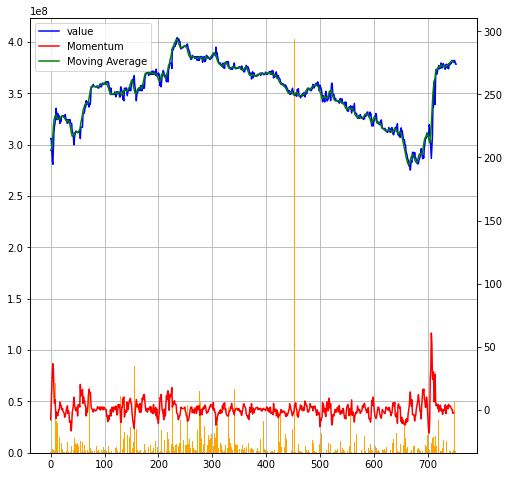

In [93]:
stock.staticgraph_Mm_Sma(5,6)

In [94]:
stock.dynamicgraph_Mm_Sma(5,6)